#### Objective

In this notebook I am testing a reduced workflow that will:

1) input a geophysical map as an image 

2) reduce the number of colours 

3) convert the image with reduced colours from RGB to HSL

4) extract unique values of H, then sort those and also the L values in the correponding pixels, by the same index

5) visualize the result as an H vs. L curve to QC of the method

6) run the perceptual test by checking for monotonicity

#### Preliminaries - import main libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, segmentation, color
from skimage.future import graph

%matplotlib inline

In [2]:
import requests
from PIL import Image
from StringIO import StringIO

#### Import test image. The colormap is Matlab's Jet

In [3]:
url = 'https://mycarta.files.wordpress.com/2015/04/jet_tight.png'
r = requests.get(url)
img = np.asarray(Image.open(StringIO(r.content)).convert('RGB'))

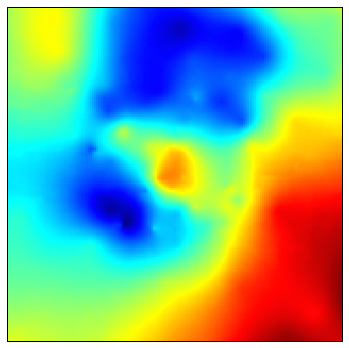

In [4]:
# plot image
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(img)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

#### Reduce number of colours

I use here Scikit-learn RAG thresholding:
http://scikit-image.org/docs/dev/auto_examples/plot_rag_mean_color.html

In [5]:
# parameters chosen by trial and error. Will have to find a way to automatically optimize them
labels1 = segmentation.slic(img, compactness=24, n_segments=300) 
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 24)
out2 = color.label2rgb(labels2, img, kind='avg')

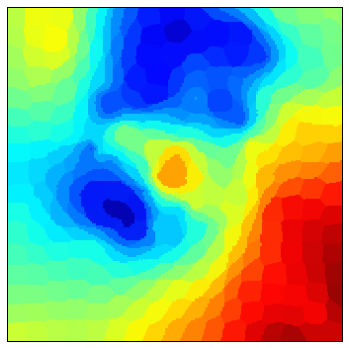

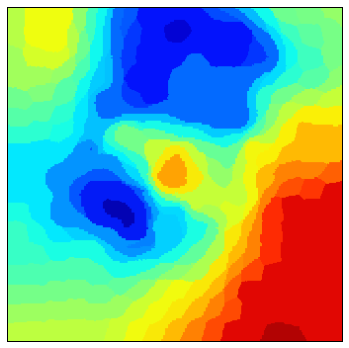

In [6]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out1)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out2)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

#### Convert from RGB to HSL, get  unique values of H, S, and L then sort both lightness L and hue H, by increasing values of H

I tried two methods that return the same result:

1) get H, L, combine into 2D array, sort unique rows

2) sort H, with index returned then sort L with index

In [7]:
width, height, dump = np.shape(out2)
print  width, height, dump

339 340 3


In [8]:
# method 1
# extract lightness and hue, combine them into a 2D array

# extract
from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb
lab = rgb2lab(out2)
lch = lab2lch(lab)
        
lab = np.asarray(lab)
lch = np.asarray(lch)


# reshape
pixels_lab = np.reshape(lab, (width*height, -1))
l1, a, b = np.split(pixels_lab, 3, axis=-1)
        
pixels_lch = np.reshape(lch, (width*height, -1))
l2, c, h = np.split(pixels_lch, 3, axis=-1)
 
# flatten    
import itertools
lM = list(itertools.chain.from_iterable(l2))
hM = list(itertools.chain.from_iterable(h))

# zip together to make 2D numpy array
lhM = np.asarray(zip(hM,lM))


In [9]:
# Sorting unique rows
# Joe Kington's answer on Stackoverflow: http://stackoverflow.com/a/16971224
def unique_rows(data):
    uniq = np.unique(data.view(data.dtype.descr * data.shape[1]))
    return uniq.view(data.dtype).reshape(-1, data.shape[1])

In [10]:
uniqLM = unique_rows(lhM)
print np.shape(uniqLM)

(86L, 2L)


In [11]:
# method 2
# sorting both lightness and hue by hue separately

from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb
lab = rgb2lab(out2)
lch = lab2lch(lab)
        
lab = np.asarray(lab)
lch = np.asarray(lch)


pixels_lab = np.reshape(lab, (width*height, -1))
l1, a, b = np.split(pixels_lab, 3, axis=-1)
        
pixels_lch = np.reshape(lch, (width*height, -1))
l2, c, h = np.split(pixels_lch, 3, axis=-1)
                
huniq, unidx = np.unique(h, return_index=True)
luniq = l2[unidx]
cuniq = c[unidx]

# flatten luniq, cuniq
import itertools 
luniqM = list(itertools.chain.from_iterable(luniq))
cuniqM = list(itertools.chain.from_iterable(cuniq))

In [12]:
# compare output of two methods
lhM2 = np.asarray(zip(huniq,luniqM))
print 'method 2'
print '         H            L' 
print lhM2[:4]
print lhM2[-4:]

print 'method 1'
print '         H            L' 
print uniqLM[:4]
print uniqLM[-4:]

method 2
         H            L
[[  0.68884048  37.00354083]
 [  0.69513721  47.19858564]
 [  0.73173924  54.87826109]
 [  0.75220755  55.99943591]]
[[  5.32481422  32.819208  ]
 [  5.33405097  32.94156838]
 [  5.34296696  21.49959684]
 [  5.34379397  26.26207126]]
method 1
         H            L
[[  0.68884048  37.00354083]
 [  0.69513721  47.19858564]
 [  0.73173924  54.87826109]
 [  0.75220755  55.99943591]]
[[  5.32481422  32.819208  ]
 [  5.33405097  32.94156838]
 [  5.34296696  21.49959684]
 [  5.34379397  26.26207126]]


#### Import a function to plot colored lines in the final plot using the colormap created above


From David Sanders:
https://github.com/dpsanders/matplotlib-examples/blob/master/colorline.ipynb

In [13]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

#### Make final plot of the sorted hue, H versus lightness, L, colored by L

C:\Users\niccom\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\niccom\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


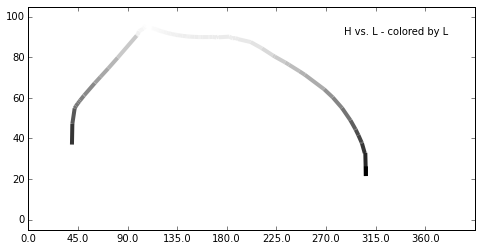

In [14]:
# To color by L, it has to be normalized to [0 1]
luniqM_n=(luniqM-min(luniqM))/(max(luniqM)-min(luniqM))

fig = plt.figure(figsize=(8,4))
plt.xticks(np.arange(0, 2.25*np.pi,0.25*np.pi),[0.,   45.,   90.,  135.,  180.,  225.,  270.,  315., 360.]) 
# Hue as 0-360 angle

ax1 = fig.add_subplot(111)

# ax1.scatter(huniq, luniq)
colorline(huniq,luniqM, luniqM_n, linewidth=4,cmap='gray')
ax1.set_xlim(0, 2.25*np.pi)
ax1.set_ylim(-5, 105)
ax1.text(5, 95, 'H vs. L - colored by L', va='top')
plt.show()

In [15]:
# as of Nov 05, 2015 after reinstalling Anaconda, using Colorline gives a future warning:
# https://github.com/dpsanders/matplotlib-examples/issues/1
# rerun above to suppress warning

#### Run perceptual test checks for monotonicity 

In [16]:
# Stackoverflo answer http://stackoverflow.com/a/4985520

def pairwise(seq):
    items = iter(seq)
    last = next(items)
    for item in items:
        yield last, item
        last = item

def strictly_increasing(L):
    return all(x<y for x, y in pairwise(L))

def strictly_decreasing(L):
    return all(x>y for x, y in pairwise(L))

def non_increasing(L):
    return all(x>=y for x, y in pairwise(L))

def non_decreasing(L):
    return all(x<=y for x, y in pairwise(L))

In [17]:
print strictly_increasing(luniq)
print non_decreasing(luniq)

print strictly_decreasing(luniq)
print non_increasing(luniq)

False
False
False
False


#### Now we try it on an abstract rainbow image

In [18]:
# Originally from: http://bgfons.com/upload/rainbow_texture1761.jpg. Resized and saved as png
url = 'https://mycarta.files.wordpress.com/2015/11/rainbow_texture17611.png'
r = requests.get(url)
img = np.asarray(Image.open(StringIO(r.content)).convert('RGB'))

In [19]:
labels1 = segmentation.slic(img, compactness=30, n_segments=300)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 24)
out2 = color.label2rgb(labels2, img, kind='avg')

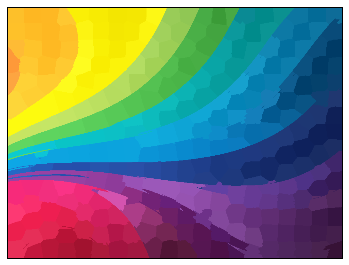

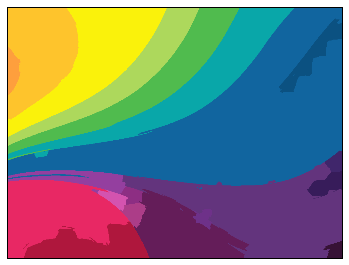

In [20]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out1)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out2)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

In [21]:
width, height, dump = np.shape(out2)
# method 2
# sorting both lightness and hue by hue separately

from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb
lab = rgb2lab(out2)
lch = lab2lch(lab)
        
lab = np.asarray(lab)
lch = np.asarray(lch)


pixels_lab = np.reshape(lab, (width*height, -1))
l1, a, b = np.split(pixels_lab, 3, axis=-1)
        
pixels_lch = np.reshape(lch, (width*height, -1))
l2, c, h = np.split(pixels_lch, 3, axis=-1)
                
huniq, unidx = np.unique(h, return_index=True)
luniq = l2[unidx]
cuniq = c[unidx]

# flatten luniq, cuniq
import itertools 
luniqM = list(itertools.chain.from_iterable(luniq))
cuniqM = list(itertools.chain.from_iterable(cuniq))

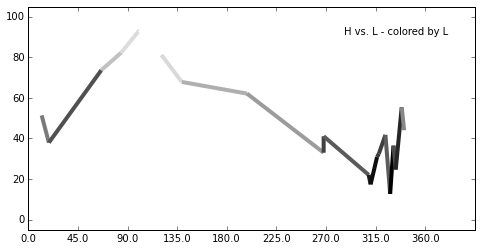

In [22]:
# To color by L, it has to be normalized to [0 1]
luniqM_n=(luniqM-min(luniqM))/(max(luniqM)-min(luniqM))

fig = plt.figure(figsize=(8,4))
plt.xticks(np.arange(0, 2.25*np.pi,0.25*np.pi),[0.,   45.,   90.,  135.,  180.,  225.,  270.,  315., 360.]) 
# Hue as 0-360 angle

ax1 = fig.add_subplot(111)

# ax1.scatter(huniq, luniq)
colorline(huniq,luniqM, luniqM_n, linewidth=4,cmap='gray')
ax1.set_xlim(0, 2.25*np.pi)
ax1.set_ylim(-5, 105)
ax1.text(5, 95, 'H vs. L - colored by L', va='top')
plt.show()

In [23]:
print strictly_increasing(luniq)
print non_decreasing(luniq)

print strictly_decreasing(luniq)
print non_increasing(luniq)

False
False
False
False


##### Try it on mycarta perceptual rainbow

In [24]:
url = 'https://mycarta.files.wordpress.com/2015/04/cubic_no_red_tight.png'
r = requests.get(url)
img = np.asarray(Image.open(StringIO(r.content)).convert('RGB'))

In [25]:
labels1 = segmentation.slic(img, compactness=30, n_segments=300)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 12)
out2 = color.label2rgb(labels2, img, kind='avg')

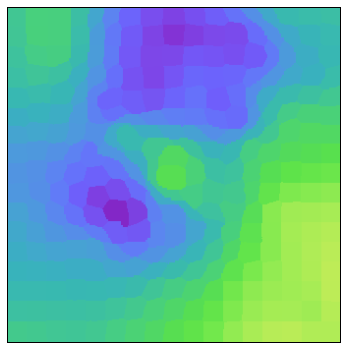

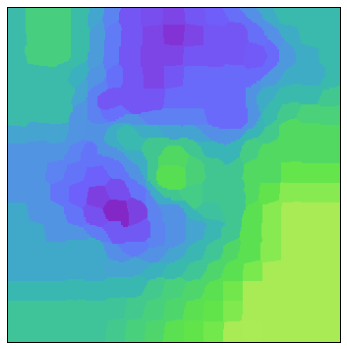

In [26]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out1)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.imshow(out2)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

In [27]:
width, height, dump = np.shape(out2)
# method 2
# sorting both lightness and hue by hue separately

from skimage.color import rgb2lab, lab2lch, lch2lab, lab2rgb
lab = rgb2lab(out2)
lch = lab2lch(lab)
        
lab = np.asarray(lab)
lch = np.asarray(lch)


pixels_lab = np.reshape(lab, (width*height, -1))
l1, a, b = np.split(pixels_lab, 3, axis=-1)
        
pixels_lch = np.reshape(lch, (width*height, -1))
l2, c, h = np.split(pixels_lch, 3, axis=-1)
                
huniq, unidx = np.unique(h, return_index=True)
luniq = l2[unidx]
cuniq = c[unidx]

# flatten luniq, cuniq
import itertools 
luniqM = list(itertools.chain.from_iterable(luniq))
cuniqM = list(itertools.chain.from_iterable(cuniq))

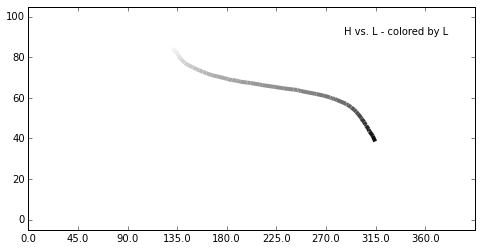

In [28]:
# To color by L, it has to be normalized to [0 1]
luniqM_n=(luniqM-min(luniqM))/(max(luniqM)-min(luniqM))

fig = plt.figure(figsize=(8,4))
plt.xticks(np.arange(0, 2.25*np.pi,0.25*np.pi),[0.,   45.,   90.,  135.,  180.,  225.,  270.,  315., 360.]) 
# Hue as 0-360 angle

ax1 = fig.add_subplot(111)

# ax1.scatter(huniq, luniq)
colorline(huniq,luniqM, luniqM_n, linewidth=4,cmap='gray')
ax1.set_xlim(0, 2.25*np.pi)
ax1.set_ylim(-5, 105)
ax1.text(5, 95, 'H vs. L - colored by L', va='top')
plt.show()

In [29]:
print strictly_increasing(luniq)
print strictly_decreasing(luniq)

print non_increasing(luniq)
print non_decreasing(luniq)

False
False
False
False


#The test should have worked but it did not.
We need to include some smoothing, or despiking to deal with small non monotonic value pairs. See below tests

[86.544132822954765, 86.204349283696786, 84.263685498914469, 83.619860049308514, 83.415599316141169, 82.512319865929754, 82.812371366274434, 81.430738171894291, 81.027111369532435, 80.768922397914935, 79.657359574573206, 78.978330807691705, 77.421470161724429, 77.125328486430334, 76.51645503846477]


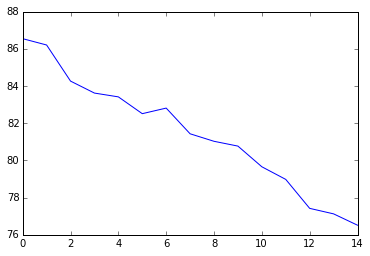

In [30]:
print luniqM[:15]
plt.plot(luniqM[:15])

#### From Matt Hall
https://github.com/kwinkunks/notebooks/blob/master/Backus.ipynb

In [31]:
def moving_average(a, length, mode='valid'):
    
    pad = np.floor(length/2)
    
    if mode == 'full': 
        pad *= 2
    
    # Make a padded version, paddding with first and last values
    r = np.empty(a.shape[0] + 2*pad)
    r[:pad] = a[0]
    r[pad:-pad] = a
    r[-pad:] = a[-1]
    
    # Cumsum with shifting trick
    s = np.cumsum(r, dtype=float)
    s[length:] = s[length:] - s[:-length]
    out = s[length-1:]/length
    
    # Decide what to return
    if mode == 'same':
        if out.shape[0] != a.shape[0]: 
            # If size doesn't match, then interpolate.
            out = (out[:-1,...] + out[1:,...]) / 2
        return out
    elif mode == 'valid':
        return out[pad:-pad]
    else: # mode=='full' and we used a double pad
        return out

C:\Users\niccom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\niccom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\niccom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\niccom\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


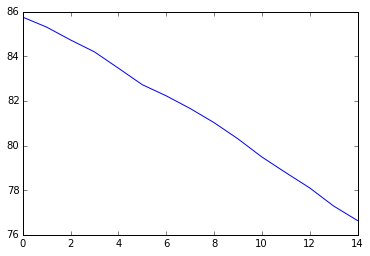

In [32]:
avg = moving_average(np.asarray(luniqM), 7, mode='same')
plt.plot(avg[:15])


This function gives a future warning:
https://github.com/kwinkunks/notebooks/issues/4

In [33]:
def moving_avg_conv(a, length):
    boxcar = np.ones(length)/length
    return np.convolve(a, boxcar, mode="valid")

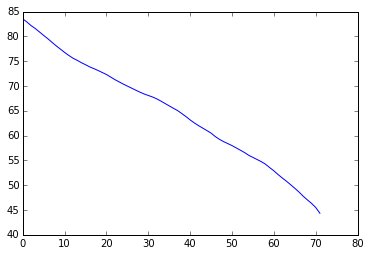

In [34]:
avg = moving_avg_conv(np.asarray(luniqM), 9)
plt.plot(avg)

In [35]:
print strictly_increasing(avg)
print non_decreasing(avg)

print strictly_decreasing(avg)
print non_increasing(avg)

False
False
True
True


This worked as expected. But you loose a few points at the edges because of mode="valid"
if using mode="same" you'd get edge effects and the monotonicity test would fail
Just something to bear in mind

In [36]:
def moving_avg_conv(a, length):
    boxcar = np.ones(length)/length
    return np.convolve(a, boxcar, mode="same")

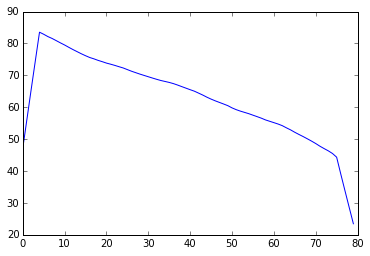

In [37]:
avg = moving_avg_conv(np.asarray(luniqM), 9)
plt.plot(avg)

In [38]:
print strictly_increasing(avg)
print non_decreasing(avg)

print strictly_decreasing(avg)
print non_increasing(avg)

False
False
False
False
